# Flood Exposure Geospatial Pipeline - Data Visualization

This notebook provides comprehensive visualizations for the geospatial analysis pipeline, including:
- **Part A**: Rainfall patterns and trends (CHIRPS data)
- **Part B**: DEM and hydrological analysis (coming soon)
- **Part C**: Flood exposure assessment (coming soon)

# Flood Exposure Geospatial Pipeline - Data Visualization

This notebook provides comprehensive visualizations for the geospatial analysis pipeline, including:
- Rainfall patterns and trends
- DEM and hydrological analysis
- Flood exposure assessment

## 1. Import Required Libraries

In [20]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from pathlib import Path

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

---

# Part A: Rainfall Analysis

## 2. Load the Rainfall Datacube

In [21]:
# Load the rainfall datacube (CHIRPS data clipped to AOI)
datacube_path = Path("../data/processed/chirps_clipped_aoi.nc")
datacube = xr.open_dataset(datacube_path)

# Display datacube information
print("Datacube Dimensions:", dict(datacube.dims))
print("\nDatacube Variables:", list(datacube.data_vars))
print("\nTime Range:", datacube.time.min().values, "to", datacube.time.max().values)
print("\nSpatial Extent:")
print(f"  Longitude: {float(datacube.longitude.min()):.4f} to {float(datacube.longitude.max()):.4f}")
print(f"  Latitude: {float(datacube.latitude.min()):.4f} to {float(datacube.latitude.max()):.4f}")

# Show the datacube structure
datacube

Datacube Dimensions: {'time': 84, 'latitude': 15, 'longitude': 16}

Datacube Variables: ['precip']

Time Range: 2018-01-01T00:00:00.000000000 to 2025-12-01T00:00:00.000000000

Spatial Extent:
  Longitude: 32.5250 to 33.2750
  Latitude: 15.6250 to 16.3250


C:\Users\Moham\AppData\Local\Temp\ipykernel_129200\4148510673.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("Datacube Dimensions:", dict(datacube.dims))


<xarray.Dataset> Size: 81kB
Dimensions:    (time: 84, latitude: 15, longitude: 16)
Coordinates:
  * time       (time) datetime64[ns] 672B 2018-01-01 2018-02-01 ... 2025-12-01
  * latitude   (latitude) float32 60B 15.62 15.67 15.72 ... 16.22 16.27 16.32
  * longitude  (longitude) float32 64B 32.52 32.57 32.62 ... 33.18 33.22 33.27
Data variables:
    precip     (time, latitude, longitude) float32 81kB ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Center
    version:           Version 2.0
    data_created:      2023-12-18
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given month. 
    acknowledgements:  The Climate Hazards Center InfraRed Precipitation with...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/chg/products/CHIRPS...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

## 3. Time Series - Average Rainfall Over AOI

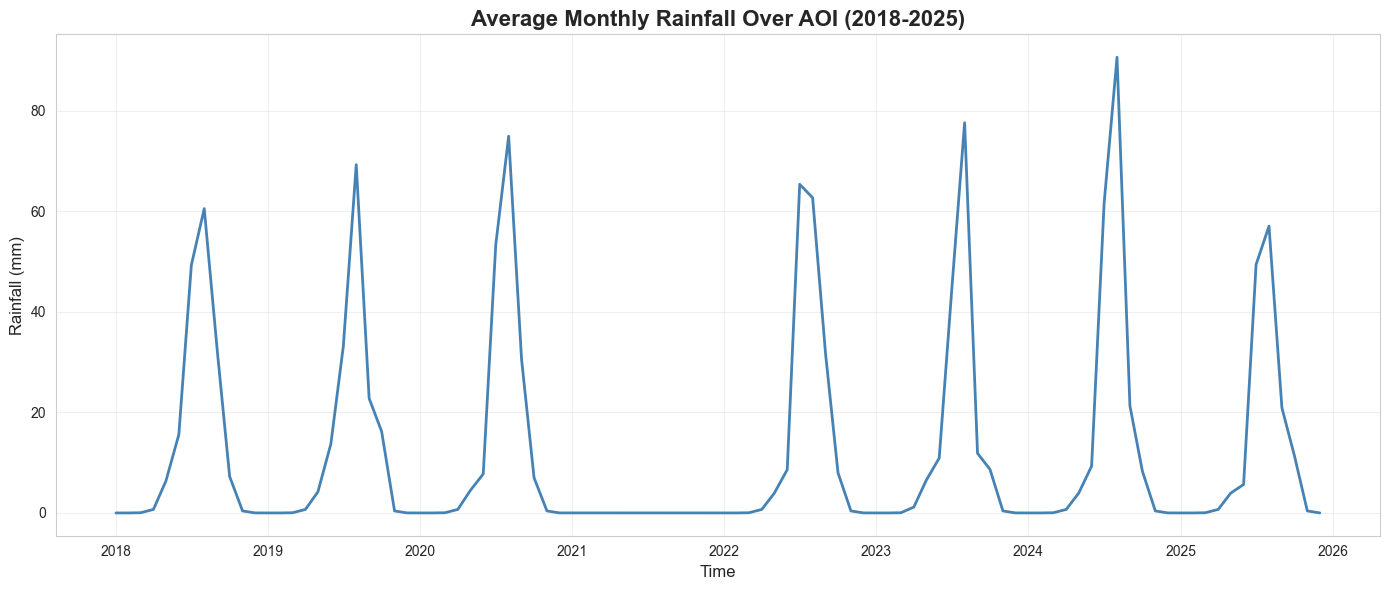


Rainfall Statistics:
  Mean: 14.30 mm
  Min: 0.00 mm
  Max: 90.65 mm
  Std Dev: 22.73 mm


In [22]:
# Calculate mean rainfall across all spatial pixels for each time step
mean_rainfall = datacube['precip'].mean(dim=['latitude', 'longitude'])

# Create time series plot
fig, ax = plt.subplots(figsize=(14, 6))
mean_rainfall.plot(ax=ax, linewidth=2, color='steelblue')
ax.set_title('Average Monthly Rainfall Over AOI (2018-2025)', fontsize=16, fontweight='bold')
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Rainfall (mm)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show statistics
print(f"\nRainfall Statistics:")
print(f"  Mean: {float(mean_rainfall.mean()):.2f} mm")
print(f"  Min: {float(mean_rainfall.min()):.2f} mm")
print(f"  Max: {float(mean_rainfall.max()):.2f} mm")
print(f"  Std Dev: {float(mean_rainfall.std()):.2f} mm")

## 4. Yearly Comparison - Monthly Rainfall by Year

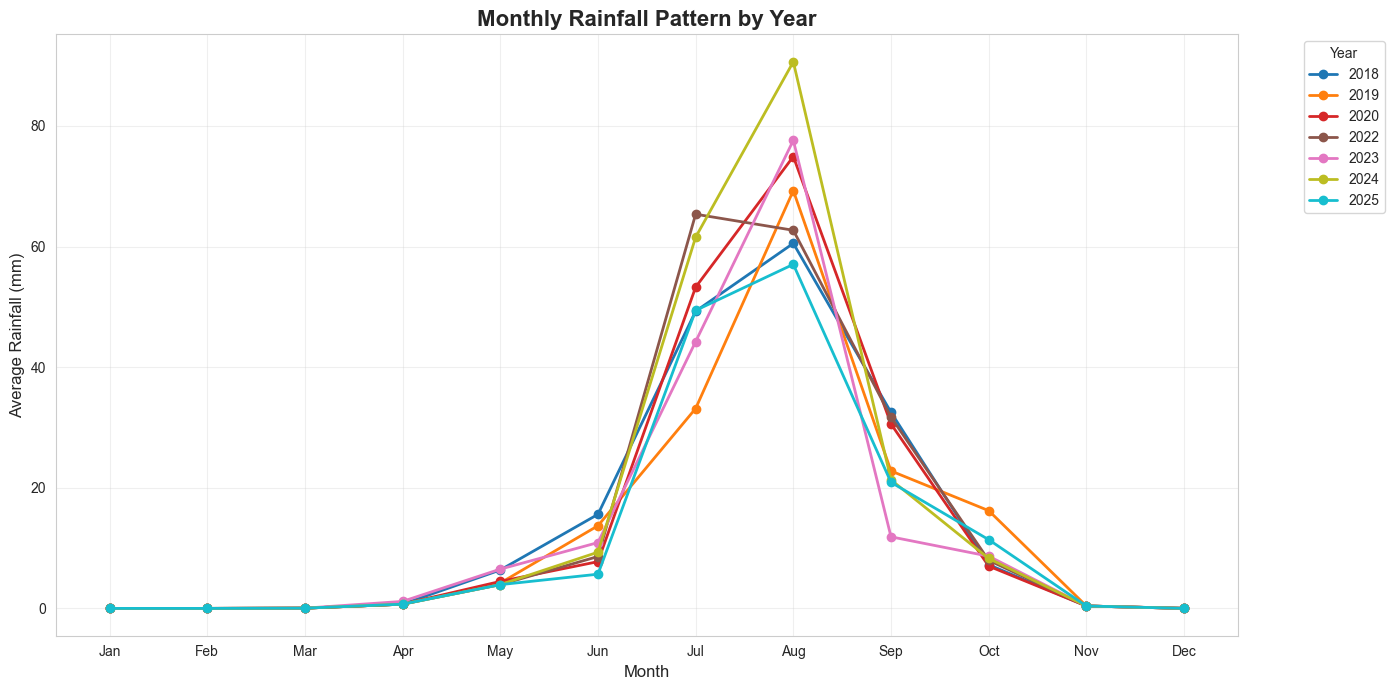

In [23]:
# Prepare data for yearly comparison
years = datacube['precip'].groupby('time.year').groups.keys()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(14, 7))

# Plot each year
colors = plt.cm.tab10(np.linspace(0, 1, len(years)))
for i, year in enumerate(sorted(years)):
    year_data = datacube['precip'].sel(time=datacube['time.year'] == year)
    monthly_means = year_data.groupby('time.month').mean(dim='time').mean(dim=['latitude', 'longitude'])
    ax.plot(range(1, len(monthly_means) + 1), monthly_means.values, 
            marker='o', linewidth=2, label=str(year), color=colors[i])

ax.set_xticks(range(1, 13))
ax.set_xticklabels(months)
ax.set_title('Monthly Rainfall Pattern by Year', fontsize=16, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Average Rainfall (mm)', fontsize=12)
ax.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Spatial Rainfall Pattern - 2025 (Last Year)

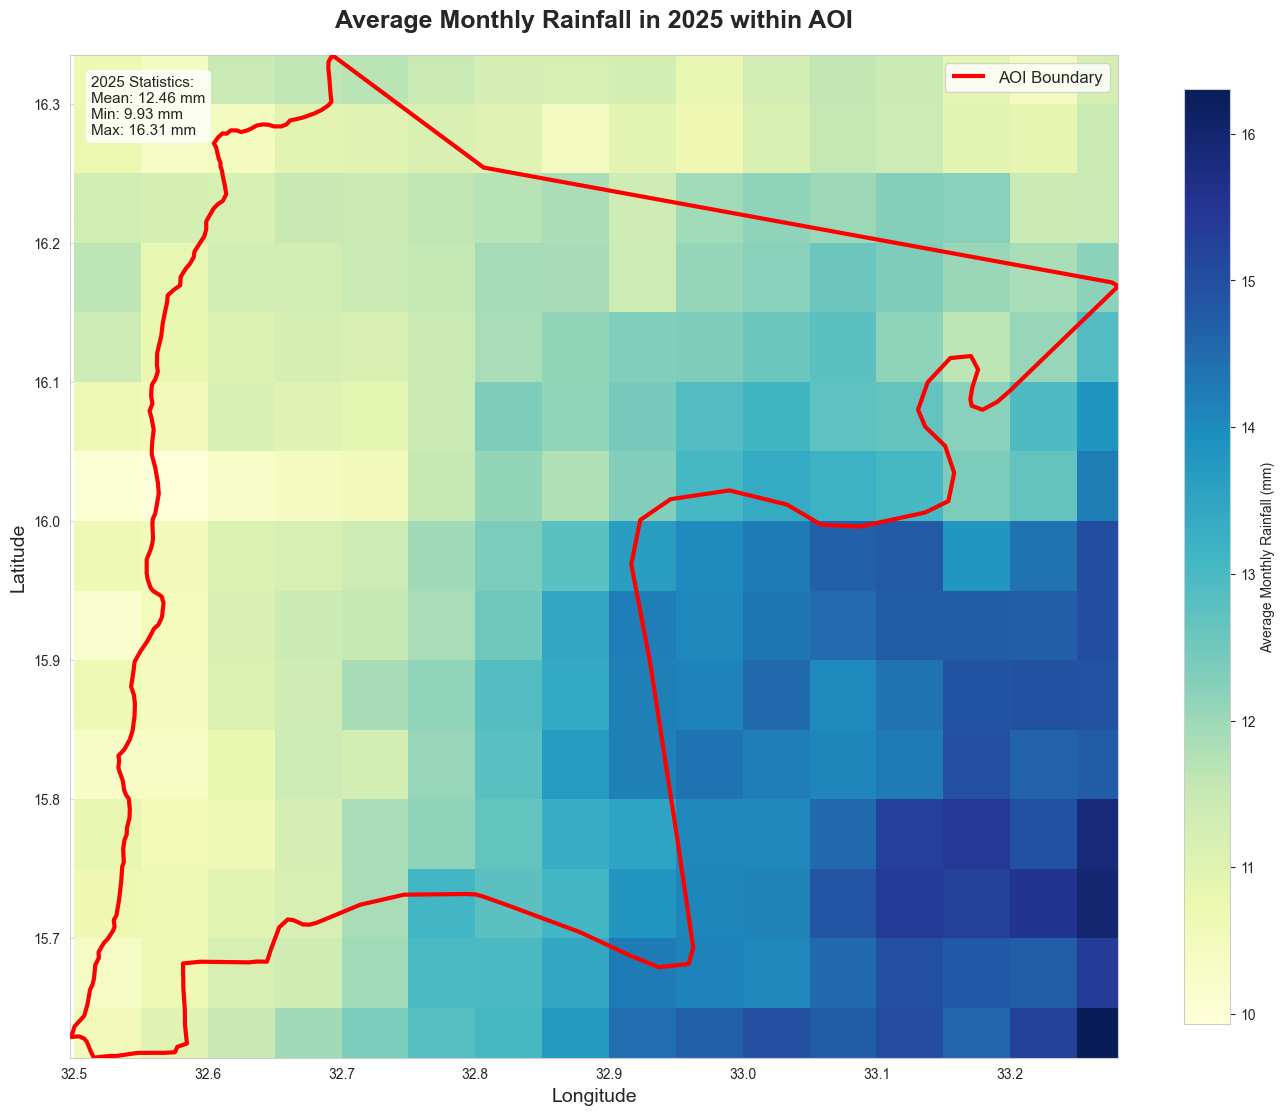


AOI Bounds: [32.4971676  15.6141559  33.28065901 16.3348999 ]
Data shape: (15, 16)


In [25]:
# Load AOI shapefile
aoi = gpd.read_file("../data/raw/vector/AOI.shp")

# Select 2025 data and calculate mean rainfall (datacube is already clipped to AOI bounding box)
rainfall_2025 = datacube['precip'].sel(time=datacube['time.year'] == 2025)
avg_rainfall_2025 = rainfall_2025.mean(dim='time')

# Create figure
fig, ax = plt.subplots(figsize=(14, 12))

# Plot the rainfall data
im = avg_rainfall_2025.plot(
    ax=ax,
    cmap='YlGnBu',
    cbar_kwargs={'label': 'Average Monthly Rainfall (mm)', 'shrink': 0.8}
)

# Overlay AOI boundary on top
aoi.boundary.plot(ax=ax, color='red', linewidth=3, label='AOI Boundary', zorder=10)

# Add title and labels
ax.set_title('Average Monthly Rainfall in 2025 within AOI', 
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--', color='gray')

# Add statistics text box
stats_text = f"2025 Statistics:\nMean: {float(avg_rainfall_2025.mean()):.2f} mm\n"
stats_text += f"Min: {float(avg_rainfall_2025.min()):.2f} mm\n"
stats_text += f"Max: {float(avg_rainfall_2025.max()):.2f} mm"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Set axis limits to AOI bounds
ax.set_xlim(aoi.total_bounds[0], aoi.total_bounds[2])
ax.set_ylim(aoi.total_bounds[1], aoi.total_bounds[3])

plt.tight_layout()
plt.show()

print(f"\nAOI Bounds: {aoi.total_bounds}")
print(f"Data shape: {avg_rainfall_2025.shape}")

---

# Part B: DEM & Hydrological Analysis

*Coming soon: Elevation models, flow accumulation, and drainage networks*

---

# Part C: Flood Exposure Assessment

*Coming soon: Building exposure analysis and risk assessment*